In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.linear_model import LinearRegression

In [2]:
with open('config.yaml','r') as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [3]:
study_dir = config['hpo']['studies_dir']
studies = os.listdir(study_dir)

study_names = [study.split('.')[0] for study in studies]
models = [model.split('_')[1] for model in study_names]
storages = [f'sqlite:///{study_dir}/{study}' for study in studies]

font_size = 16

In [4]:
studies = [optuna.load_study(study_name=study, storage=storage) for study, storage in zip(study_names, storages)]

### Best Trial

In [5]:
for model, study in enumerate(studies):
    print('Best trial of', models[model])
    trial = study.best_trial

    print(f'  Error: {trial.value}')
    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
    print()

Best trial of tcn
  Error: 0.3522624373435974
  Params: 
    batch_size: 16
    epochs: 50
    n_layers: 4
    lr: 0.0004374686795424248
    filters: 64
    kernel_size: 2

Best trial of d-pvod
  Error: 0.02353094480931759
  Params: 
    batch_size: 98
    epochs: 46
    lr: 0.003237976315291346
    filters: 58
    kernel_size: 3
    n_cnn_layers: 4
    units: 107
    n_rnn_layers: 4



In [6]:
def ten_best(study):
    trials = [trial for trial in study.trials if trial.value is not None]
    sorted_trials = sorted(trials, key=lambda x: x.value)
    print("Top 10 Trials:", '\n')
    for trial in sorted_trials[:10]:
        print(f"Trial {trial.number}: MAE = {trial.value}")
        print(f"  Params: {trial.params}")
        print()

HPO Progess of model: tcn
Improvement per Trial: 0.0002257251592536642


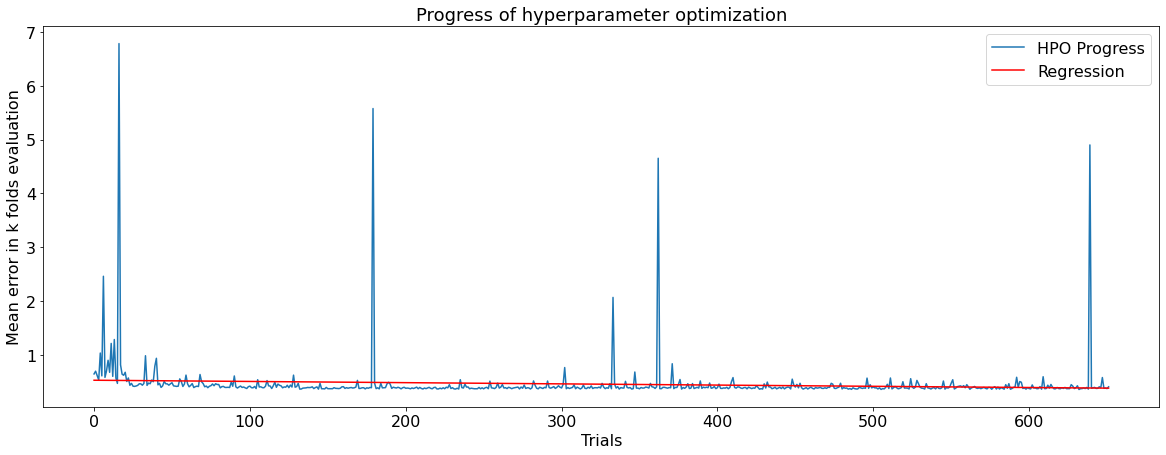

HPO Progess of model: d-pvod
Improvement per Trial: 0.000512939486105675


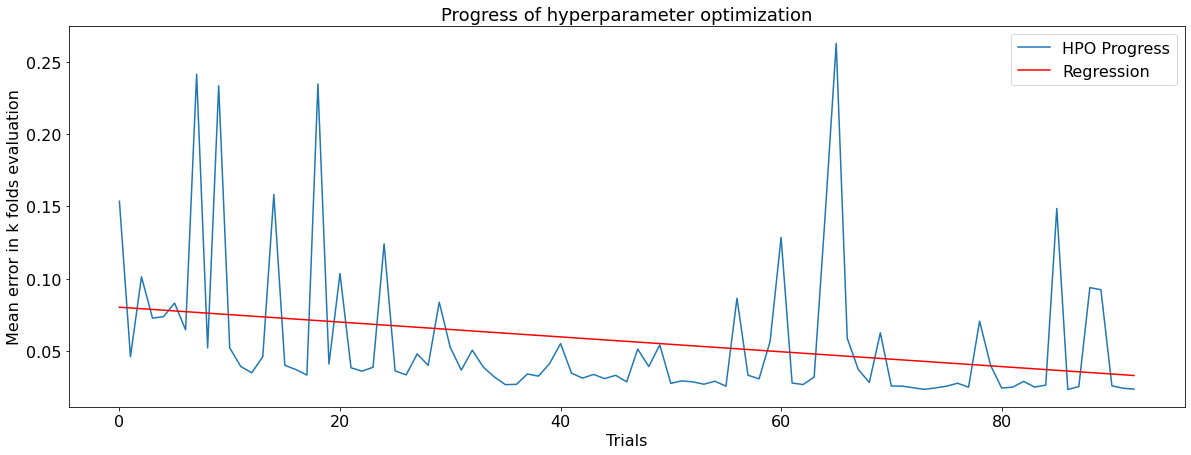

In [7]:
for model, study in enumerate(studies):
    print('HPO Progess of model:', models[model])
    trials = [trial for trial in study.trials if trial.value is not None]
    sorted_trials = sorted(trials, key=lambda x: x.value)
    sorted_by_number = sorted(trials, key=lambda x: x.number)
    progress = [trial.values for trial in sorted_by_number]
    x = np.arange(len(progress)).reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x, progress)
    y_pred = lr.predict(x)
    plt.figure(figsize=(20,7))
    print('Improvement per Trial:', lr.coef_[0][0]*-1)
    plt.plot(progress, label='HPO Progress')
    plt.plot(y_pred, 'r-', label='Regression')
    plt.title('Progress of hyperparameter optimization', fontsize=font_size+2)
    plt.xlabel('Trials', fontsize=font_size)
    plt.ylabel('Mean error in k folds evaluation', fontsize=font_size)
    ax = plt.gca()  # Get current axes
    ax.tick_params(axis='x', labelsize=font_size)  # Schriftgröße für x-Achsenmarkierungen
    ax.tick_params(axis='y', labelsize=font_size)
    plt.legend(fontsize=font_size)
    plt.show()